Epoch [1/20], Step [100/391], Loss: 2.0622
Epoch [1/20], Step [200/391], Loss: 1.8080
Epoch [1/20], Step [300/391], Loss: 1.6463
Epoch [1/20]:
Train Loss: 0.3610, Train Acc: 32.40%
Test Loss: 1.4600, Test Acc: 46.23%
Epoch [2/20], Step [100/391], Loss: 1.4544
Epoch [2/20], Step [200/391], Loss: 1.3828
Epoch [2/20], Step [300/391], Loss: 1.3533
Epoch [2/20]:
Train Loss: 0.2989, Train Acc: 49.08%
Test Loss: 1.1864, Test Acc: 56.58%
Epoch [3/20], Step [100/391], Loss: 1.2628
Epoch [3/20], Step [200/391], Loss: 1.2082
Epoch [3/20], Step [300/391], Loss: 1.1978
Epoch [3/20]:
Train Loss: 0.2655, Train Acc: 56.64%
Test Loss: 1.0944, Test Acc: 60.64%
Epoch [4/20], Step [100/391], Loss: 1.1065
Epoch [4/20], Step [200/391], Loss: 1.0738
Epoch [4/20], Step [300/391], Loss: 1.0503
Epoch [4/20]:
Train Loss: 0.2377, Train Acc: 62.21%
Test Loss: 0.9080, Test Acc: 67.81%
Epoch [5/20], Step [100/391], Loss: 0.9801
Epoch [5/20], Step [200/391], Loss: 0.9826
Epoch [5/20], Step [300/391], Loss: 0.9390
Epo

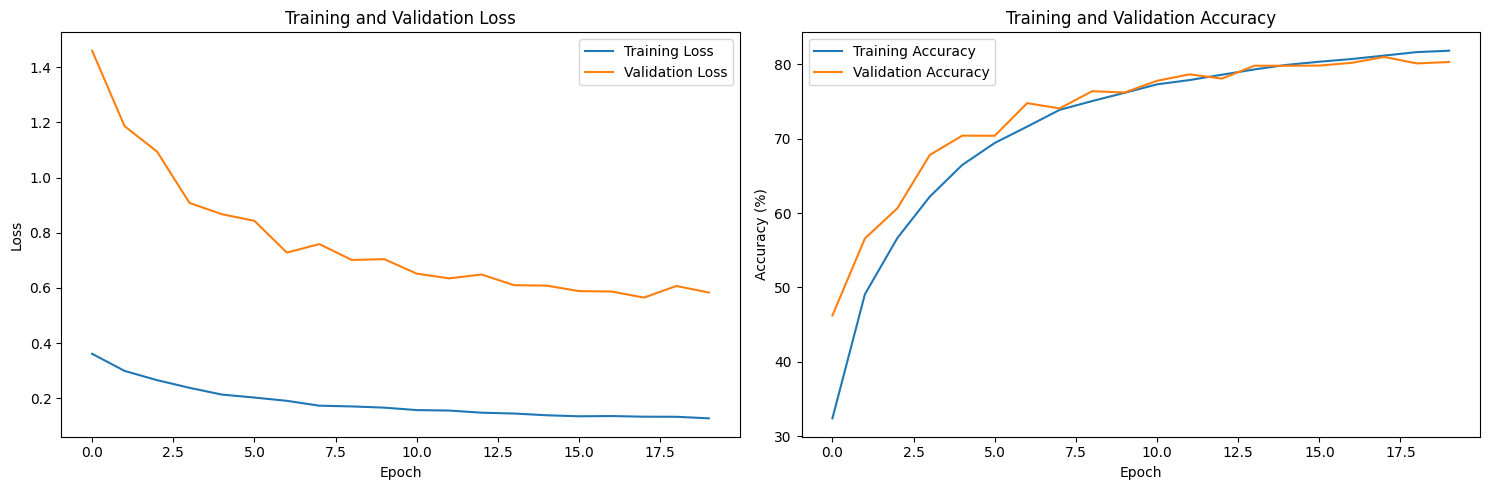

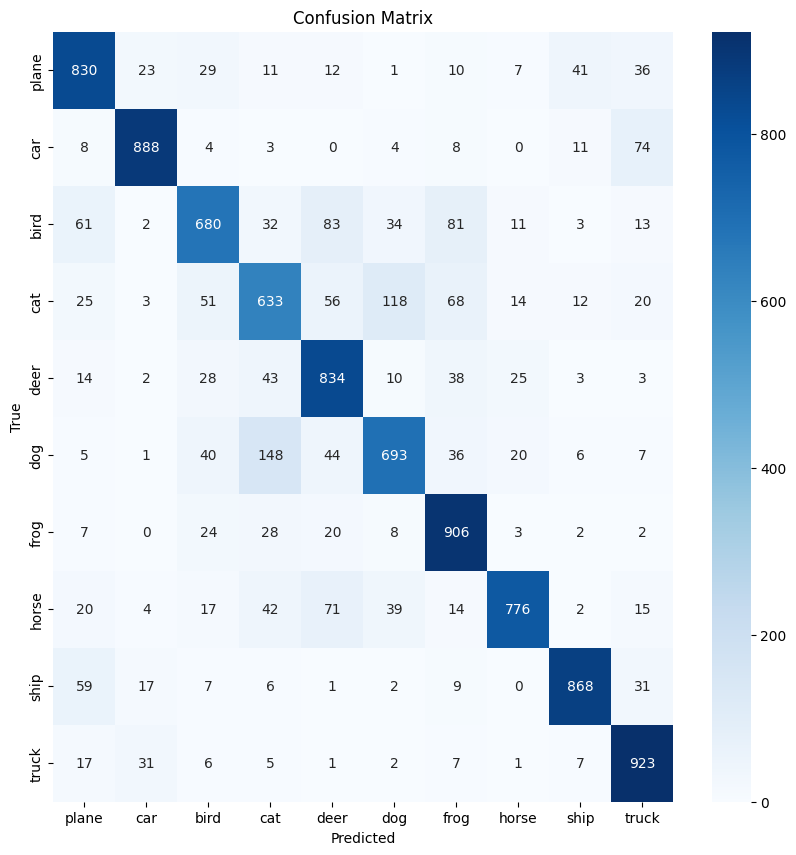


Overall Accuracy: 80.31%

Per-class metrics:
Class		Precision	Recall		F1-Score
------------------------------------------------------------
plane       	   79.35%	   83.00%	   81.13%
car         	   91.45%	   88.80%	   90.11%
bird        	   76.75%	   68.00%	   72.11%
cat         	   66.56%	   63.30%	   64.89%
deer        	   74.33%	   83.40%	   78.61%
dog         	   76.07%	   69.30%	   72.53%
frog        	   76.98%	   90.60%	   83.23%
horse       	   90.55%	   77.60%	   83.58%
ship        	   90.89%	   86.80%	   88.80%
truck       	   82.12%	   92.30%	   86.91%

Macro-averaged metrics:
Precision: 80.50%
Recall: 80.31%
F1-Score: 80.19%


In [3]:
## AlexNet -> CIFAR-10


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

#NUM_EPOCHS
num_epochs = 20

#  AlexNet model adapted for CIFAR-10
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: input [3, 32, 32] -> output [64, 32, 32]
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [64, 16, 16]
            
            # Conv2: output [192, 16, 16]
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [192, 8, 8]
            
            # Conv3: output [384, 8, 8]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv4: output [256, 8, 8]
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv5: output [256, 8, 8] then pool to [256, 4, 4]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier: Adjusted for a feature map size of 4x4 after pooling.
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Calculate epoch training metrics
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate epoch validation metrics
    epoch_test_loss = val_loss / len(testloader)
    epoch_test_acc = 100 * correct / total
    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')

print('Finished Training')

# Count and print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal number of parameters: {total_params:,}')

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable parameters: {trainable_params:,}')


# Plot the curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Compute and plot confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
# Calculate precision, recall, f1-score for each class
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
accuracy = accuracy_score(all_labels, all_preds)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy*100:.2f}%\n")

# Print per-class metrics
print("Per-class metrics:")
print("Class\t\tPrecision\tRecall\t\tF1-Score")
print("-" * 60)
for i in range(len(classes)):
    print(f"{classes[i]:<12}\t{precision[i]*100:>8.2f}%\t{recall[i]*100:>8.2f}%\t{f1[i]*100:>8.2f}%")

# Print macro-averaged metrics
macro_precision = precision.mean()
macro_recall = recall.mean() 
macro_f1 = f1.mean()

print("\nMacro-averaged metrics:")
print(f"Precision: {macro_precision*100:.2f}%")
print(f"Recall: {macro_recall*100:.2f}%") 
print(f"F1-Score: {macro_f1*100:.2f}%")



Epoch [1/50], Step [100/391], Loss: 4.4112, Acc: 3.73%
Epoch [1/50], Step [200/391], Loss: 3.9360, Acc: 5.93%
Epoch [1/50], Step [300/391], Loss: 3.6854, Acc: 7.95%
Epoch [1/50] Test Accuracy: 17.31%
Epoch [2/50], Step [100/391], Loss: 3.3294, Acc: 17.91%
Epoch [2/50], Step [200/391], Loss: 3.2359, Acc: 18.81%
Epoch [2/50], Step [300/391], Loss: 3.1043, Acc: 20.04%
Epoch [2/50] Test Accuracy: 28.30%
Epoch [3/50], Step [100/391], Loss: 2.8713, Acc: 26.80%
Epoch [3/50], Step [200/391], Loss: 2.7848, Acc: 27.61%
Epoch [3/50], Step [300/391], Loss: 2.7406, Acc: 28.24%
Epoch [3/50] Test Accuracy: 29.71%
Epoch [4/50], Step [100/391], Loss: 2.5794, Acc: 32.91%
Epoch [4/50], Step [200/391], Loss: 2.5464, Acc: 33.19%
Epoch [4/50], Step [300/391], Loss: 2.5003, Acc: 33.51%
Epoch [4/50] Test Accuracy: 39.95%
Epoch [5/50], Step [100/391], Loss: 2.3407, Acc: 37.23%
Epoch [5/50], Step [200/391], Loss: 2.3516, Acc: 37.39%
Epoch [5/50], Step [300/391], Loss: 2.3264, Acc: 37.79%
Epoch [5/50] Test Accur

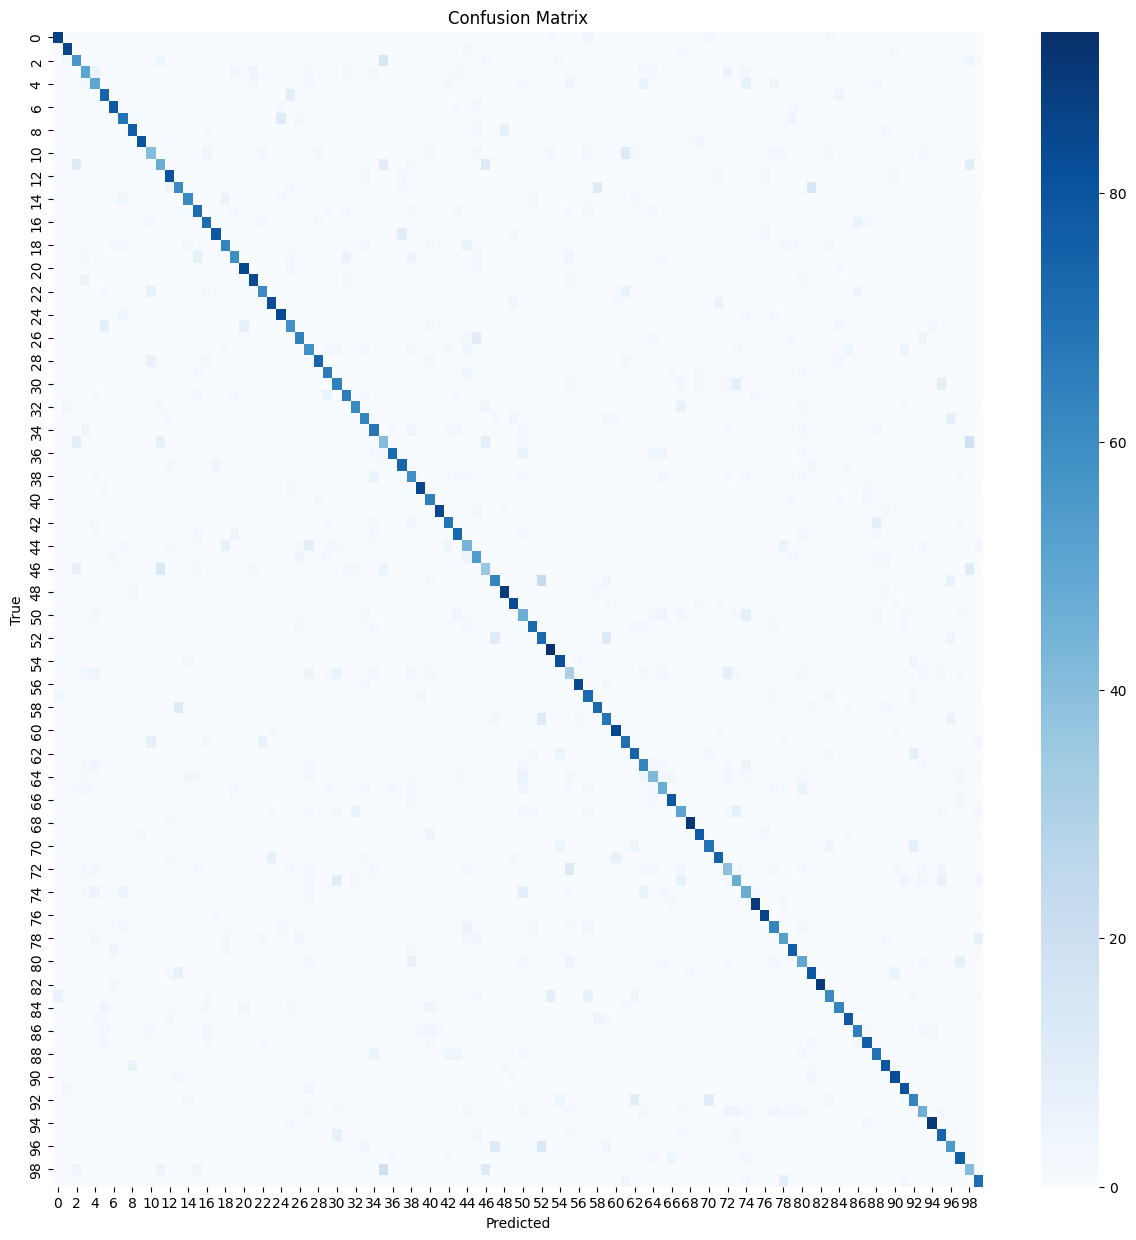

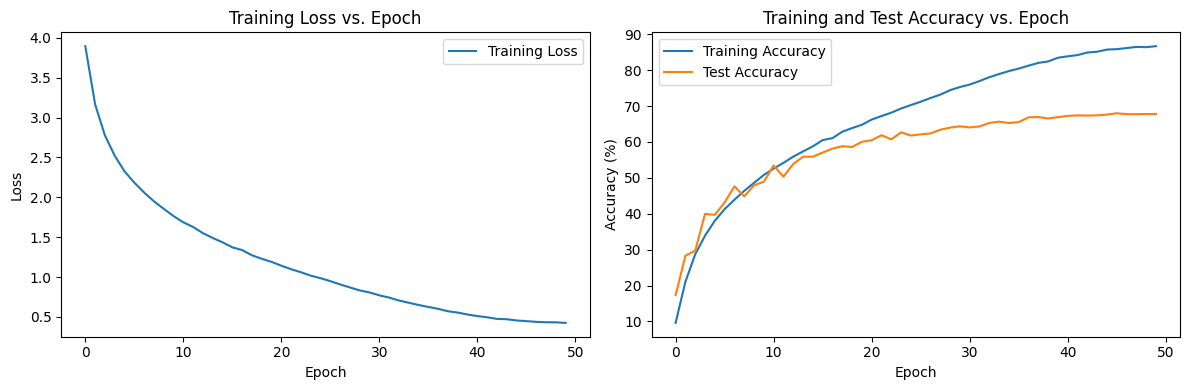

In [4]:
## AlexNet -> CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# AlexNet- CIFAR-100
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: input [3, 32, 32] -> output [64, 32, 32]
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [64, 16, 16]
            
            # Conv2: output [192, 16, 16]
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [192, 8, 8]
            
            # Conv3: output [384, 8, 8]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            # Conv4: output [256, 8, 8]
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Conv5: output [256, 8, 8] then pool to [256, 4, 4]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier: Adjusted for a feature map size of 4x4 after pooling.
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=100).to(device)

# Training loop
## NUM EPOCHS
num_epochs = 50 

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Compute confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Total Parameters: 33,646,666
Trainable Parameters: 33,646,666
Epoch [1/20], Step [100/391], Loss: 2.0674, Acc: 19.25%
Epoch [1/20], Step [200/391], Loss: 1.7007, Acc: 26.51%
Epoch [1/20], Step [300/391], Loss: 1.4998, Acc: 32.23%
Epoch [1/20] Test Accuracy: 54.57%
Epoch [2/20], Step [100/391], Loss: 1.2533, Acc: 55.06%
Epoch [2/20], Step [200/391], Loss: 1.1493, Acc: 56.93%
Epoch [2/20], Step [300/391], Loss: 1.0767, Acc: 58.57%
Epoch [2/20] Test Accuracy: 64.42%
Epoch [3/20], Step [100/391], Loss: 0.9219, Acc: 67.56%
Epoch [3/20], Step [200/391], Loss: 0.9004, Acc: 67.86%
Epoch [3/20], Step [300/391], Loss: 0.8710, Acc: 68.37%
Epoch [3/20] Test Accuracy: 70.23%
Epoch [4/20], Step [100/391], Loss: 0.7730, Acc: 73.19%
Epoch [4/20], Step [200/391], Loss: 0.7435, Acc: 73.62%
Epoch [4/20], Step [300/391], Loss: 0.7605, Acc: 73.66%
Epoch [4/20] Test Accuracy: 74.19%
Epoch [5/20], Step [100/391], Loss: 0.6743, Acc: 76.98%
Epoch [5/20], Step [200/391], Loss: 0.6493, Acc: 77.33%
Epoch [5/20], 

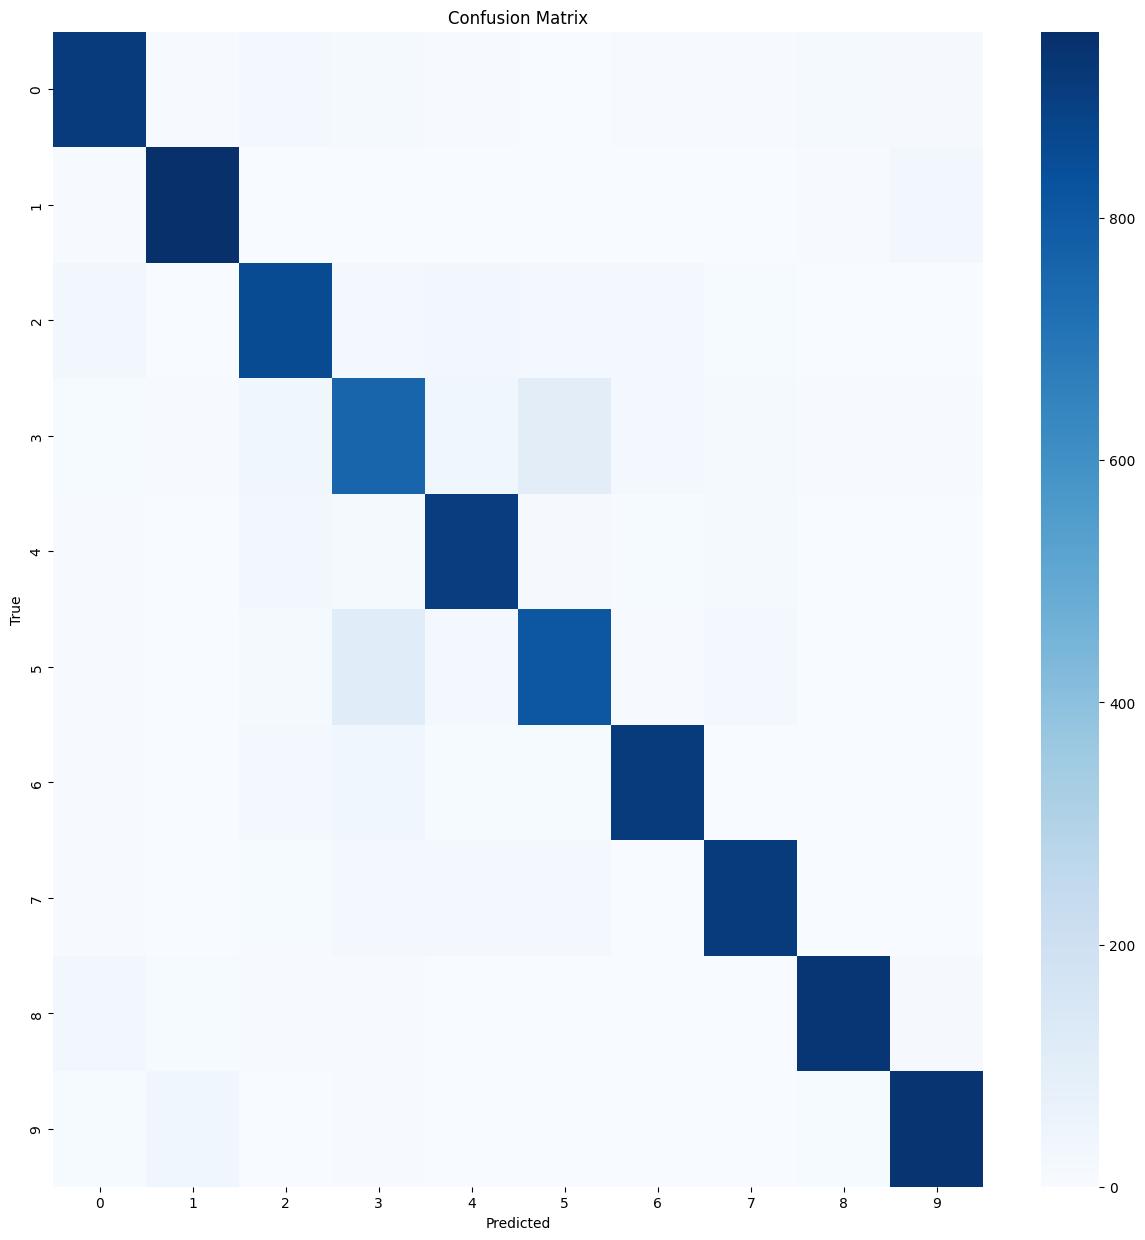

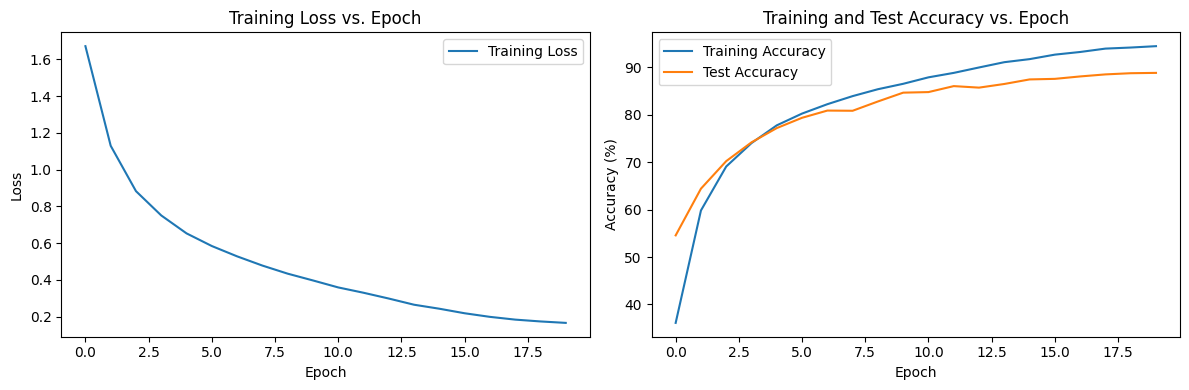

In [5]:
## VGG Net -> CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np


## NUM EPOCHS
num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# VGG16 for CIFAR-10 (only changing num_classes default)
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        # Block 1
        self.features = nn.Sequential(
            # Block 1 (64 channels)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2 (128 channels)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3 (256 channels)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4 (512 channels)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5 (512 channels)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 1 * 1, 4096),  # CIFAR-10 images are 32x32, after 5 max-pooling layers: 1x1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=10).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Total Parameters: 34,015,396
Trainable Parameters: 34,015,396
Epoch [1/20], Step [100/391], Loss: 4.5571, Acc: 1.47%
Epoch [1/20], Step [200/391], Loss: 4.4058, Acc: 2.23%
Epoch [1/20], Step [300/391], Loss: 4.1700, Acc: 3.24%
Epoch [1/20] Test Accuracy: 7.96%
Epoch [2/20], Step [100/391], Loss: 3.8618, Acc: 8.59%
Epoch [2/20], Step [200/391], Loss: 3.7492, Acc: 9.34%
Epoch [2/20], Step [300/391], Loss: 3.6307, Acc: 10.17%
Epoch [2/20] Test Accuracy: 12.13%
Epoch [3/20], Step [100/391], Loss: 3.4424, Acc: 15.09%
Epoch [3/20], Step [200/391], Loss: 3.3658, Acc: 15.67%
Epoch [3/20], Step [300/391], Loss: 3.2916, Acc: 16.15%
Epoch [3/20] Test Accuracy: 19.16%
Epoch [4/20], Step [100/391], Loss: 3.1297, Acc: 20.63%
Epoch [4/20], Step [200/391], Loss: 3.0552, Acc: 21.32%
Epoch [4/20], Step [300/391], Loss: 2.9595, Acc: 22.14%
Epoch [4/20] Test Accuracy: 26.61%
Epoch [5/20], Step [100/391], Loss: 2.7970, Acc: 26.88%
Epoch [5/20], Step [200/391], Loss: 2.7834, Acc: 27.01%
Epoch [5/20], Step [

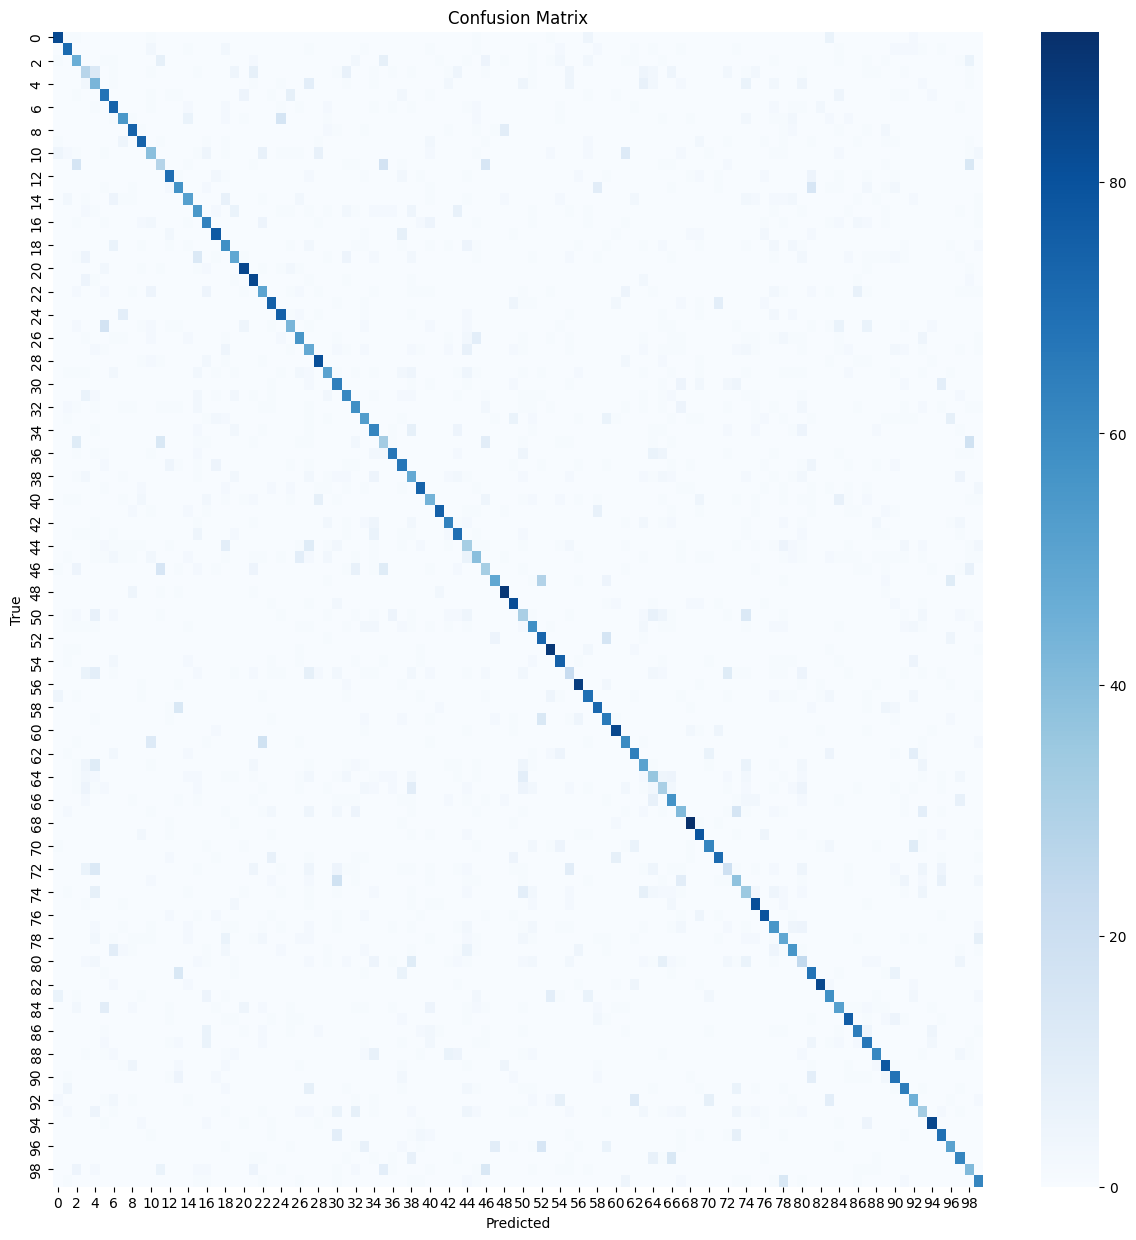

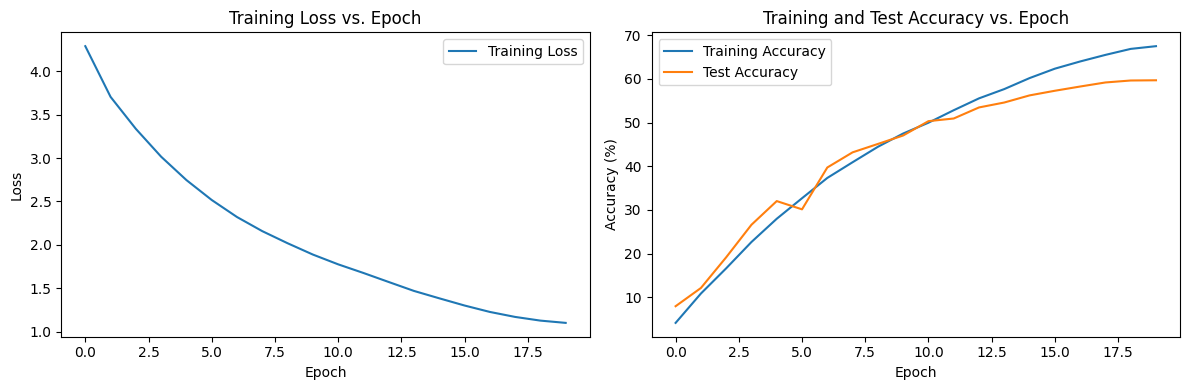

In [6]:
## VGG Net ->CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

## NUM EPOCHS
num_epochs = 20

# VGG16 for CIFAR-100
class VGG16(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16, self).__init__()
        # Block 1
        self.features = nn.Sequential(
            # Block 1 (64 channels)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2 (128 channels)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3 (256 channels)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4 (512 channels)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5 (512 channels)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 1 * 1, 4096),  # CIFAR-100 images are 32x32, after 5 max-pooling layers: 1x1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=100).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Total Parameters: 4,903,242
Trainable Parameters: 4,903,242
Epoch [1/20], Step [100/391], Loss: 1.9593, Acc: 25.35%
Epoch [1/20], Step [200/391], Loss: 1.6449, Acc: 31.73%
Epoch [1/20], Step [300/391], Loss: 1.5026, Acc: 35.98%
Epoch [1/20] Test Accuracy: 48.98%
Epoch [2/20], Step [100/391], Loss: 1.3204, Acc: 52.21%
Epoch [2/20], Step [200/391], Loss: 1.2644, Acc: 53.23%
Epoch [2/20], Step [300/391], Loss: 1.1761, Acc: 54.66%
Epoch [2/20] Test Accuracy: 61.27%
Epoch [3/20], Step [100/391], Loss: 1.0623, Acc: 61.64%
Epoch [3/20], Step [200/391], Loss: 1.0245, Acc: 62.54%
Epoch [3/20], Step [300/391], Loss: 1.0072, Acc: 62.99%
Epoch [3/20] Test Accuracy: 65.39%
Epoch [4/20], Step [100/391], Loss: 0.8980, Acc: 68.16%
Epoch [4/20], Step [200/391], Loss: 0.8642, Acc: 68.41%
Epoch [4/20], Step [300/391], Loss: 0.8492, Acc: 69.01%
Epoch [4/20] Test Accuracy: 62.90%
Epoch [5/20], Step [100/391], Loss: 0.7769, Acc: 72.19%
Epoch [5/20], Step [200/391], Loss: 0.7604, Acc: 72.76%
Epoch [5/20], St

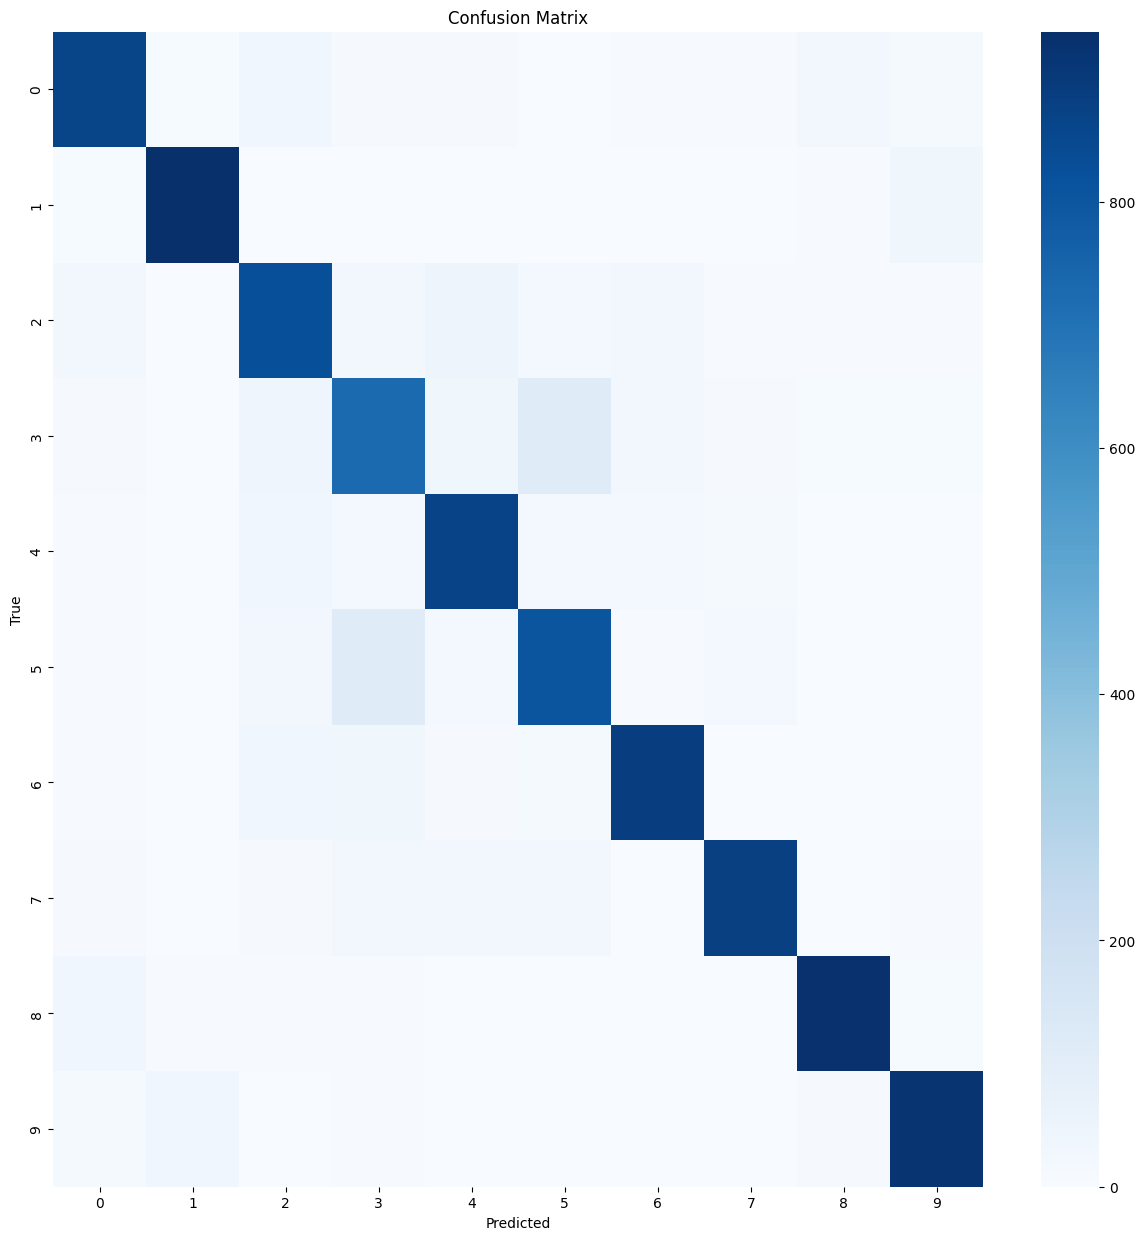

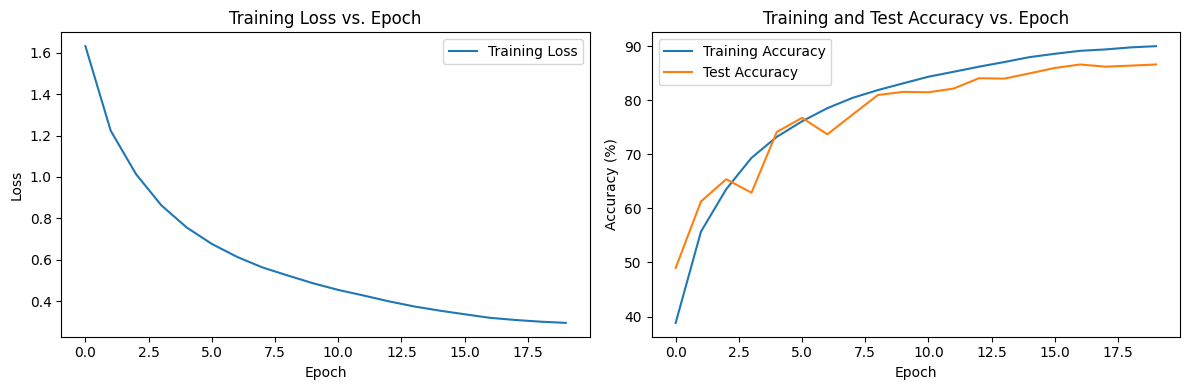

In [7]:
## ResNet11 -> CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np


## NUM EPOCHS
num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet11
class ResNet11(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet11, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet blocks
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.layer3 = BasicBlock(128, 256, stride=2)
        self.layer4 = BasicBlock(256, 512, stride=2)
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=10).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Total Parameters: 4,949,412
Trainable Parameters: 4,949,412
Epoch [1/20], Step [100/391], Loss: 4.3726, Acc: 4.12%
Epoch [1/20], Step [200/391], Loss: 4.0067, Acc: 6.35%
Epoch [1/20], Step [300/391], Loss: 3.8337, Acc: 7.70%
Epoch [1/20] Test Accuracy: 13.08%
Epoch [2/20], Step [100/391], Loss: 3.5923, Acc: 14.48%
Epoch [2/20], Step [200/391], Loss: 3.5009, Acc: 15.11%
Epoch [2/20], Step [300/391], Loss: 3.3869, Acc: 16.13%
Epoch [2/20] Test Accuracy: 19.52%
Epoch [3/20], Step [100/391], Loss: 3.2006, Acc: 21.53%
Epoch [3/20], Step [200/391], Loss: 3.1326, Acc: 22.08%
Epoch [3/20], Step [300/391], Loss: 3.0822, Acc: 22.70%
Epoch [3/20] Test Accuracy: 25.34%
Epoch [4/20], Step [100/391], Loss: 2.8883, Acc: 27.38%
Epoch [4/20], Step [200/391], Loss: 2.8547, Acc: 27.84%
Epoch [4/20], Step [300/391], Loss: 2.8008, Acc: 28.15%
Epoch [4/20] Test Accuracy: 28.04%
Epoch [5/20], Step [100/391], Loss: 2.6634, Acc: 32.12%
Epoch [5/20], Step [200/391], Loss: 2.5903, Acc: 32.55%
Epoch [5/20], Step 

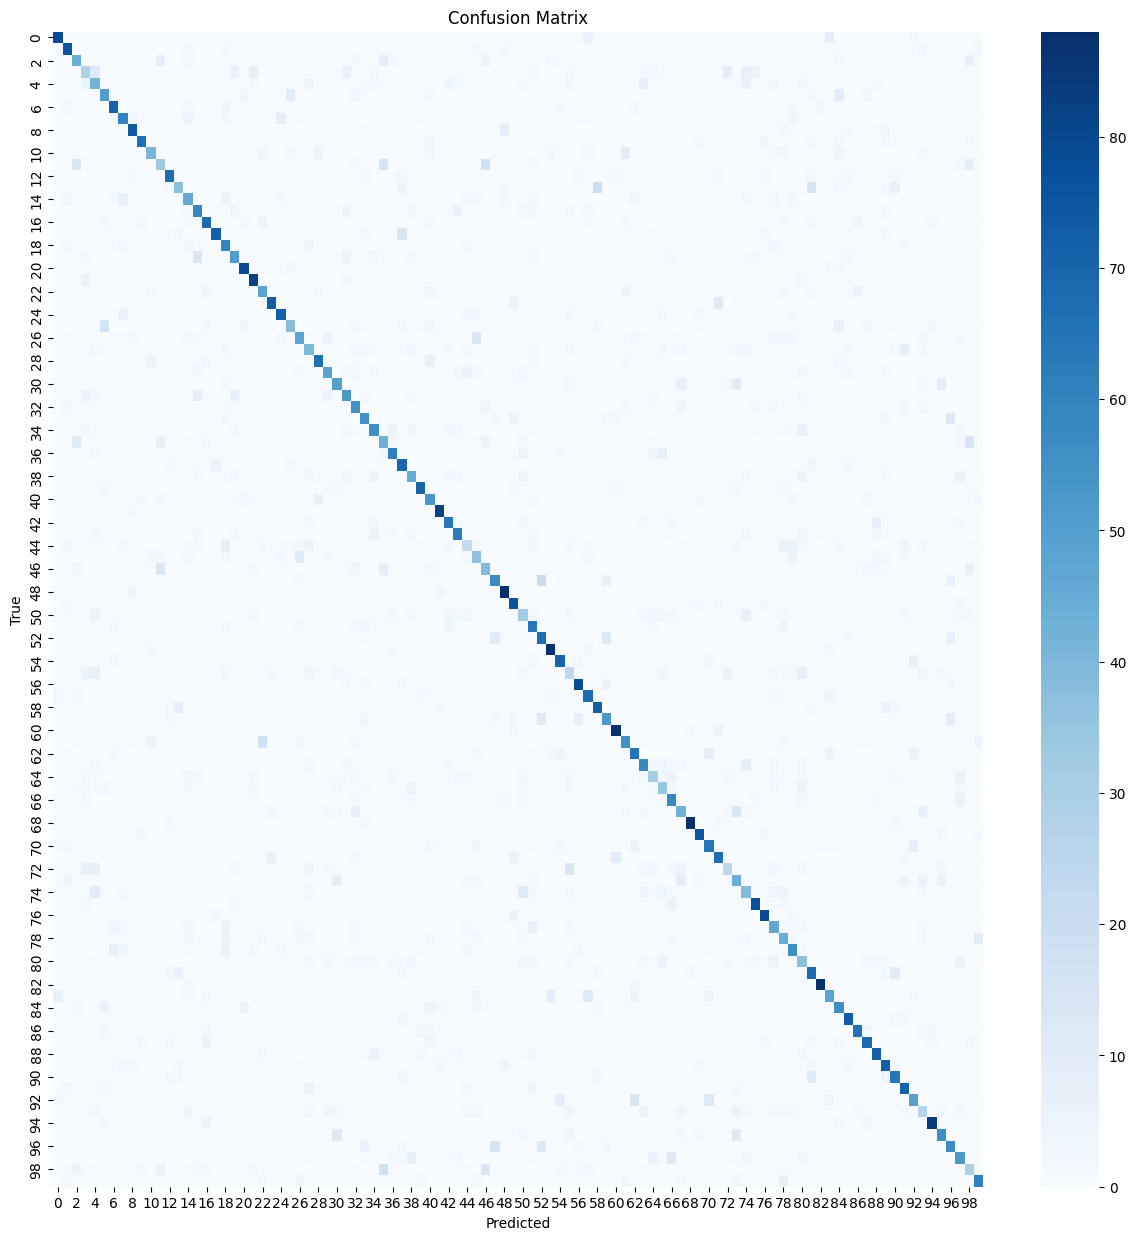

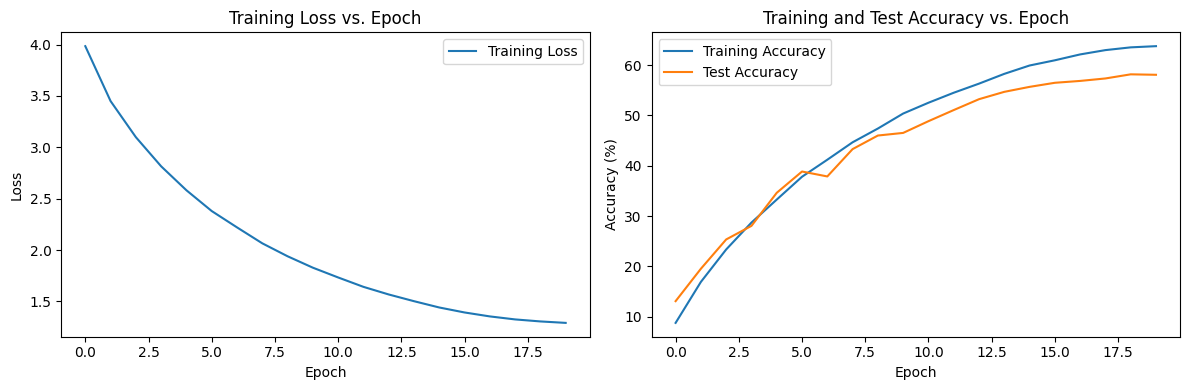

In [8]:
## ResNet11 -> CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np


## NUM EPOCHS
num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet11
class ResNet11(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet11, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet blocks
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.layer3 = BasicBlock(128, 256, stride=2)
        self.layer4 = BasicBlock(256, 512, stride=2)
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=100).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Total Parameters: 11,173,962
Trainable Parameters: 11,173,962
Epoch [1/20], Step [100/391], Loss: 1.9945, Acc: 23.52%
Epoch [1/20], Step [200/391], Loss: 1.6452, Acc: 30.83%
Epoch [1/20], Step [300/391], Loss: 1.4807, Acc: 35.42%
Epoch [1/20] Test Accuracy: 53.57%
Epoch [2/20], Step [100/391], Loss: 1.2658, Acc: 53.98%
Epoch [2/20], Step [200/391], Loss: 1.1658, Acc: 56.11%
Epoch [2/20], Step [300/391], Loss: 1.0898, Acc: 57.72%
Epoch [2/20] Test Accuracy: 60.70%
Epoch [3/20], Step [100/391], Loss: 0.9508, Acc: 65.91%
Epoch [3/20], Step [200/391], Loss: 0.8912, Acc: 67.26%
Epoch [3/20], Step [300/391], Loss: 0.8596, Acc: 68.04%
Epoch [3/20] Test Accuracy: 69.76%
Epoch [4/20], Step [100/391], Loss: 0.7518, Acc: 73.02%
Epoch [4/20], Step [200/391], Loss: 0.7254, Acc: 73.62%
Epoch [4/20], Step [300/391], Loss: 0.7240, Acc: 73.99%
Epoch [4/20] Test Accuracy: 75.28%
Epoch [5/20], Step [100/391], Loss: 0.6471, Acc: 77.06%
Epoch [5/20], Step [200/391], Loss: 0.6282, Acc: 77.64%
Epoch [5/20], 

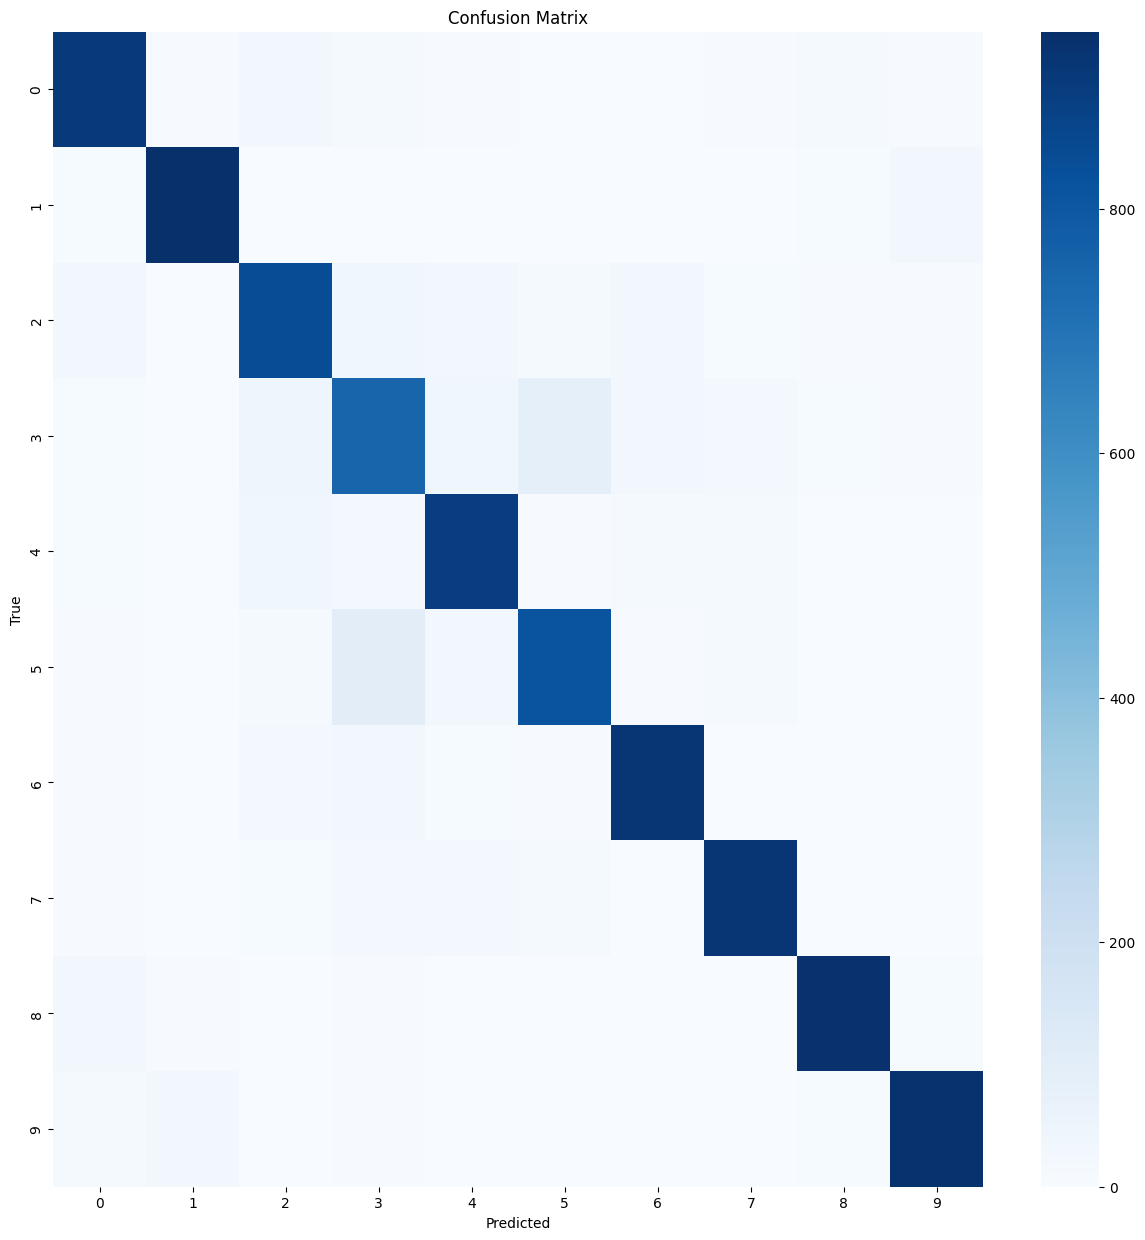

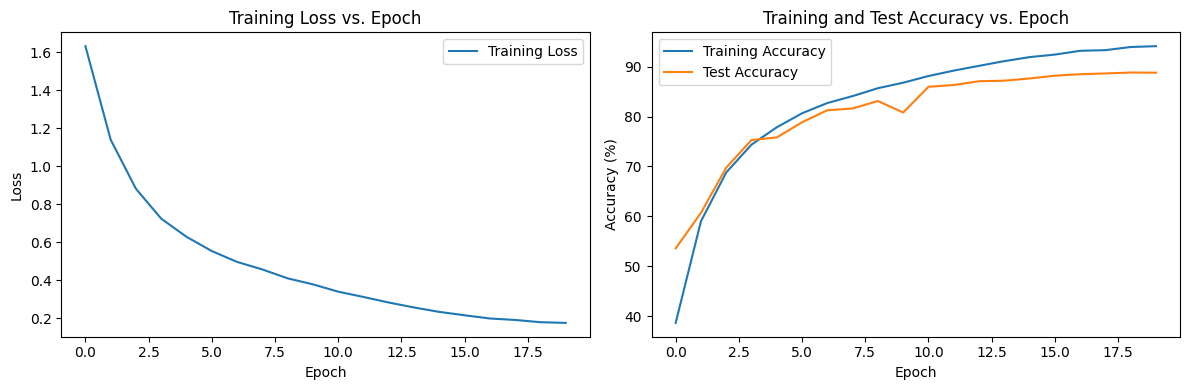

In [9]:
## ResNet18 -> CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np


## NUM EPOCHS
num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet18
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet layers
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512)
        )
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=10).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Total Parameters: 11,220,132
Trainable Parameters: 11,220,132
Epoch [1/20], Step [100/391], Loss: 4.4103, Acc: 3.27%
Epoch [1/20], Step [200/391], Loss: 3.9808, Acc: 5.87%
Epoch [1/20], Step [300/391], Loss: 3.7572, Acc: 7.80%
Epoch [1/20] Test Accuracy: 13.66%
Epoch [2/20], Step [100/391], Loss: 3.4960, Acc: 15.43%
Epoch [2/20], Step [200/391], Loss: 3.3766, Acc: 16.63%
Epoch [2/20], Step [300/391], Loss: 3.2731, Acc: 17.81%
Epoch [2/20] Test Accuracy: 22.96%
Epoch [3/20], Step [100/391], Loss: 2.9934, Acc: 25.09%
Epoch [3/20], Step [200/391], Loss: 2.9176, Acc: 25.72%
Epoch [3/20], Step [300/391], Loss: 2.8298, Acc: 26.60%
Epoch [3/20] Test Accuracy: 30.50%
Epoch [4/20], Step [100/391], Loss: 2.6207, Acc: 31.52%
Epoch [4/20], Step [200/391], Loss: 2.5244, Acc: 32.76%
Epoch [4/20], Step [300/391], Loss: 2.4749, Acc: 33.54%
Epoch [4/20] Test Accuracy: 37.21%
Epoch [5/20], Step [100/391], Loss: 2.3124, Acc: 38.38%
Epoch [5/20], Step [200/391], Loss: 2.2768, Acc: 38.95%
Epoch [5/20], Ste

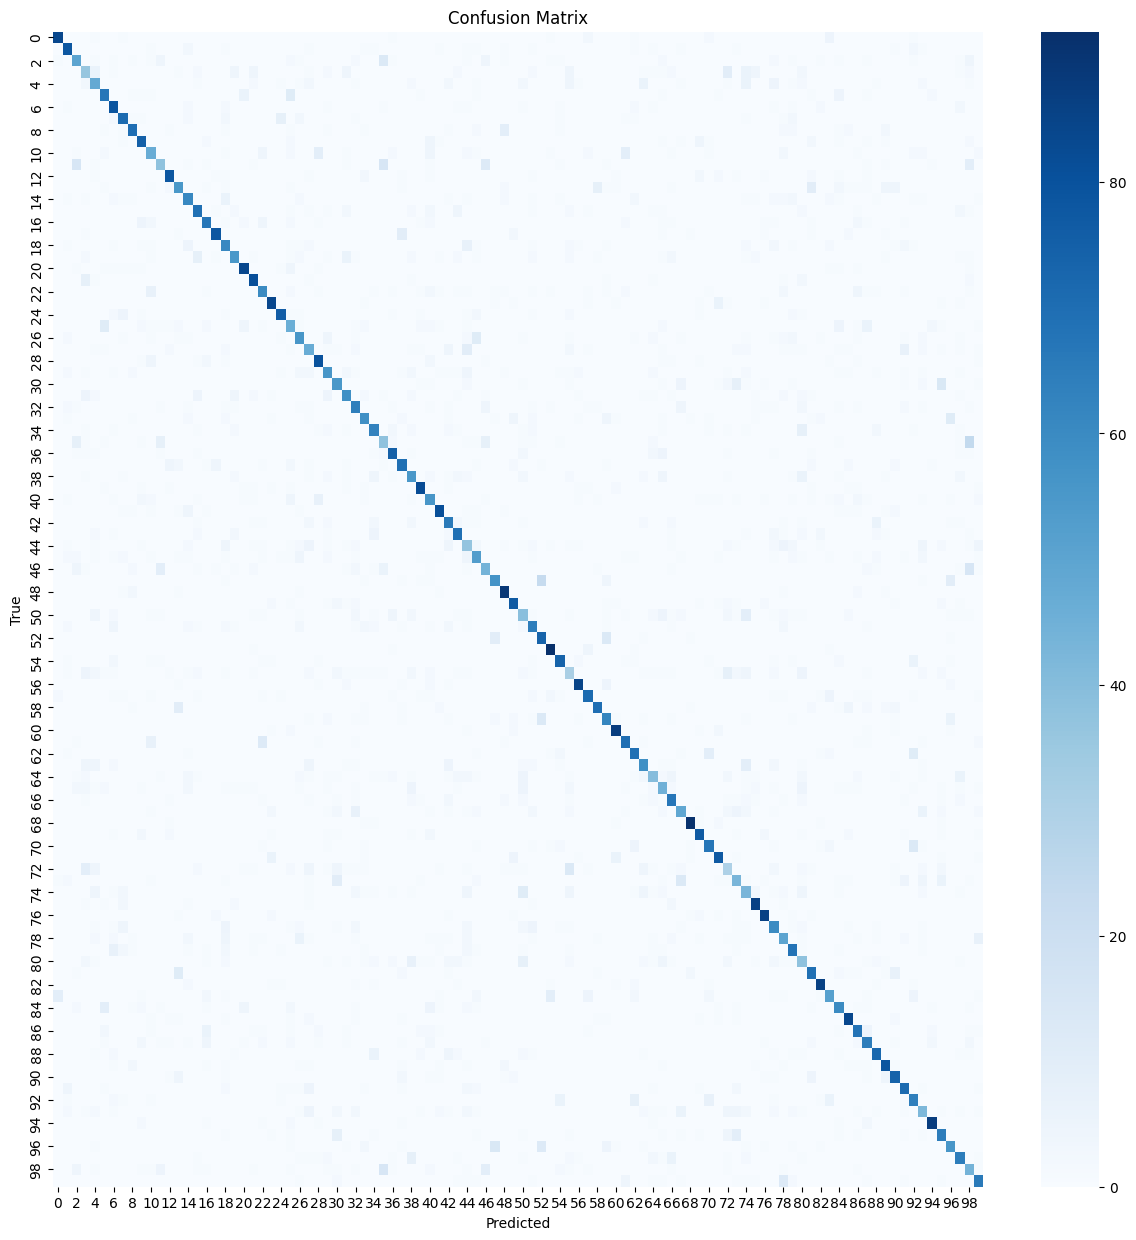

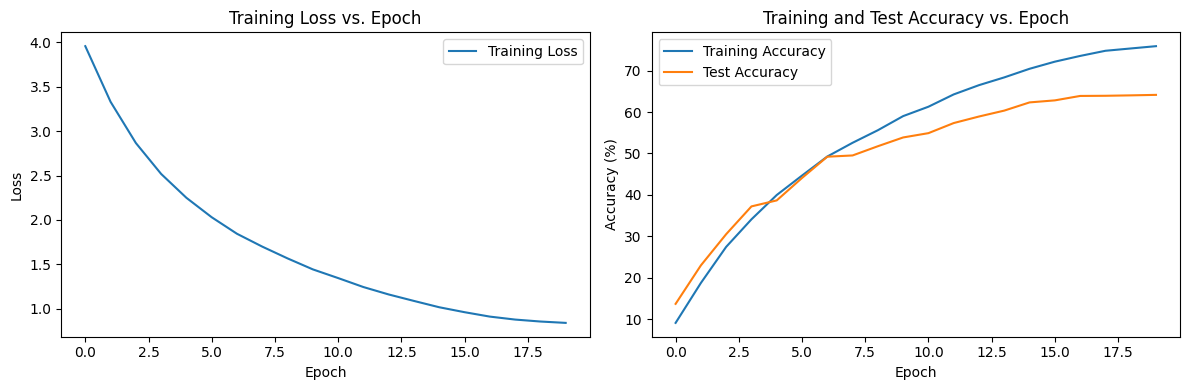

In [10]:
## ResNet11 -> CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np


## NUM EPOCHS
num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet18
class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet layers
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512)
        )
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=100).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')


model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
